In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, plot_roc_curve

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
dataset = pd.read_csv('Absenteeism_at_work.csv', sep=';')

In [4]:
dataset.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [5]:
dataset.drop(columns=['ID'], inplace=True)
dataset['Reason for absence'] = dataset['Reason for absence'].astype('category')
dataset['Month of absence'] = dataset['Month of absence'].astype('category')
dataset['Day of the week'] = dataset['Day of the week'].astype('category')
dataset['Seasons'] = dataset['Seasons'].astype('category')
dataset['Education'] = dataset['Education'].astype('category')
dataset['Absenteeism time in hours'] = dataset['Absenteeism time in hours'].astype('category')

In [6]:
dataset.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


Намерено создаем дубликаты

In [7]:
border = 5
target_value_counts = dataset['Absenteeism time in hours'].value_counts()
poor_targets = list(target_value_counts[target_value_counts < border].index)

features = dataset.columns
target = 'Absenteeism time in hours'

for poor_target in poor_targets:
    samples_count = border - target_value_counts[poor_target]
    for _ in range(samples_count):
        random_row = dataset.sample()
        for feature in features:
            random_row[feature] = dataset[feature].sample().values[0]
        random_row[target] = poor_target
        dataset = pd.concat([dataset, random_row], ignore_index=True)

dataset

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,19,12,3,4,330,26,12,33,246.074,99,0,1,0,1,0,8,83,171,25,7
760,23,5,5,4,233,26,14,38,251.818,99,0,1,3,1,0,0,65,168,27,104
761,27,7,5,2,291,25,11,33,326.452,88,0,1,1,0,0,0,65,170,25,104
762,23,8,3,1,246,12,13,50,239.554,96,0,1,0,1,0,0,89,171,25,104


In [8]:
X = dataset.drop(columns=['Absenteeism time in hours'])
y = dataset['Absenteeism time in hours']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

In [10]:
n_estimators_values = range(10, 500, 5)
for n_estimators in n_estimators_values:
    clf = RandomForestClassifier(
        max_depth=7,
        n_estimators=n_estimators
    )
    cv_score = cross_val_score(clf, X_train, y_train, cv=3)
    if np.mean(cv_score) >= 0.6:
        print(n_estimators)
        break

In [11]:
clf_rfc = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = {
        'max_depth': list(range(5, 11)),
        'n_estimators': list(range(50, 150, 5)),
        'random_state': [0]
    },
    cv = 3
)

In [12]:
clf_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [13]:
clf_rfc.best_params_

{'max_depth': 7, 'n_estimators': 135, 'random_state': 0}

In [14]:
clf_rfc.best_score_

0.4853457172342621

In [15]:
roc_auc_score(np.array(y_train), clf_rfc.predict_proba(X_train), multi_class='ovo')

0.9878720301079102

In [16]:
roc_auc_score(np.array(y_test), clf_rfc.predict_proba(X_test), multi_class='ovo')

0.6794488945462144

In [17]:
clf_gbc = GridSearchCV(
    estimator = GradientBoostingClassifier(),
    param_grid = {
        'max_depth': list(range(2, 6)),
        'n_estimators': list(range(100, 150, 5)),
        'random_state': [0],
        'max_features': ['sqrt', 'log2', None],
        'learning_rate': [0.15]
    },
    cv = 3
)

In [18]:
clf_gbc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [19]:
clf_gbc.best_params_

{'learning_rate': 0.15,
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 105,
 'random_state': 0}

In [20]:
clf_gbc.best_score_

0.4461644306845545

In [21]:
roc_auc_score(np.array(y_test), clf_gbc.predict_proba(X_test), multi_class='ovo')

0.6629025391425442

In [22]:
clf_gbc = GradientBoostingClassifier(
    random_state = 0,
    learning_rate = 0.15,
    subsample = 1.0,
    max_depth = 3,
    max_features = 'auto'
)
clf_gbc.fit(X_train, y_train)
clf_gbc.score(X_test, y_test)

0.47035573122529645

In [23]:
def build_plots(fpr, tpr, roc_auc, classes):
    for i, klass in enumerate(classes):
        plt.figure()
        lw = 2
        plt.plot(fpr[i],
                 tpr[i],
                 color='darkorange',
                 lw=lw,
                 label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for class %s' % klass)
        plt.legend(loc="lower right")
        plt.show()

In [24]:
classes = dataset['Absenteeism time in hours'].unique()
n_classes = len(classes)

In [25]:
def calc_and_plot(clf, X_test, y_test):
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = clf_rfc.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
    build_plots(fpr, tpr, roc_auc, classes)

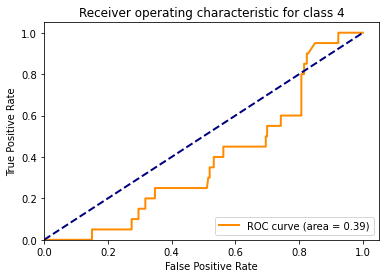

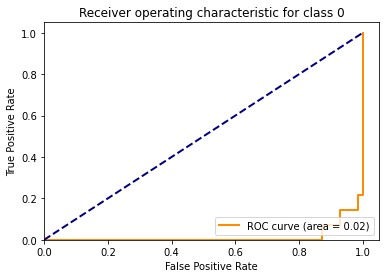

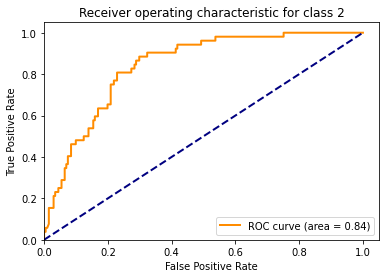

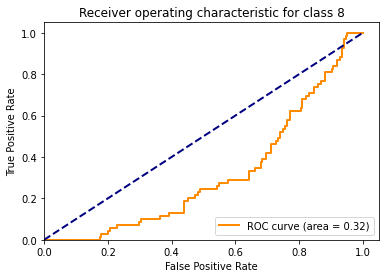

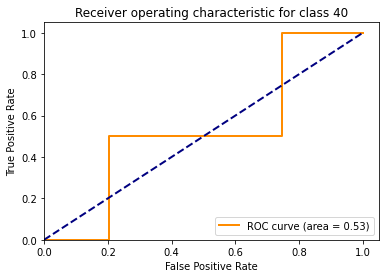

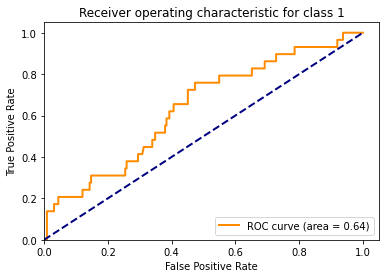

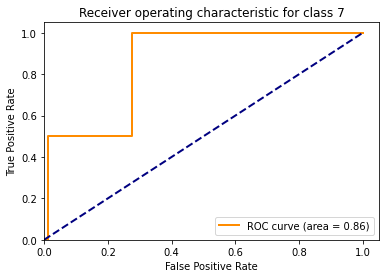

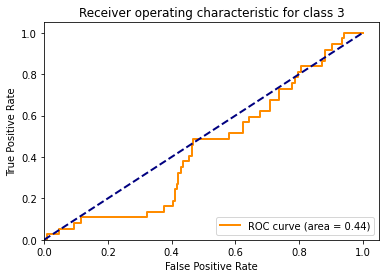

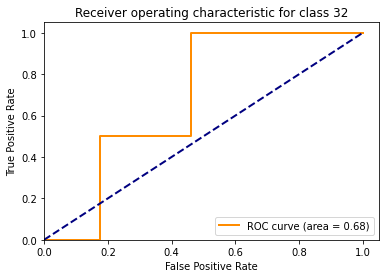

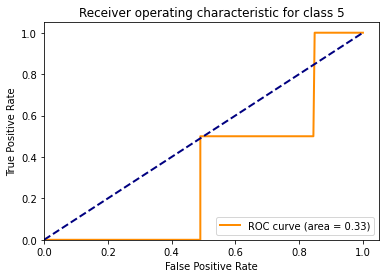

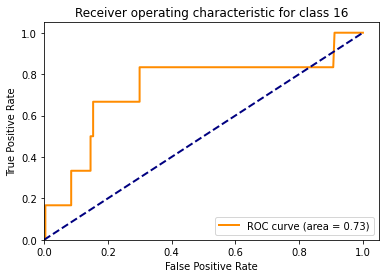

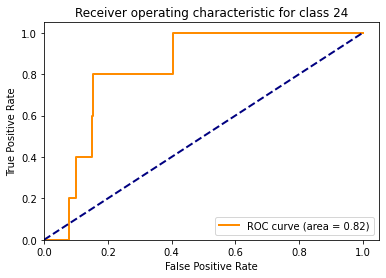

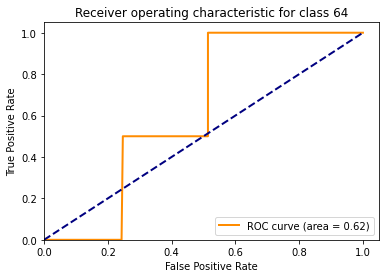

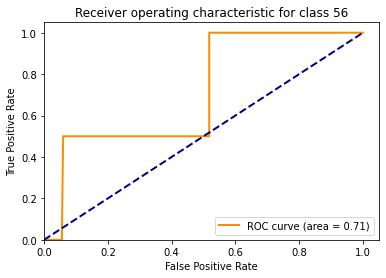

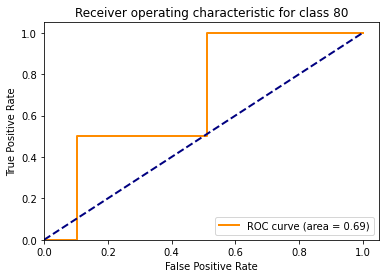

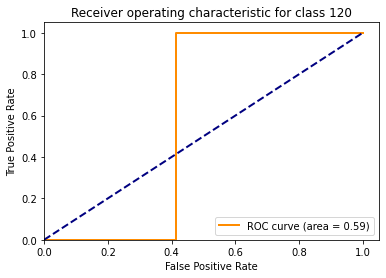

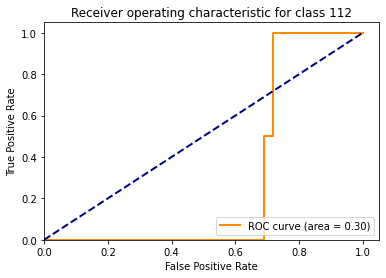

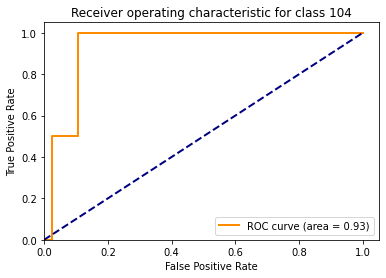

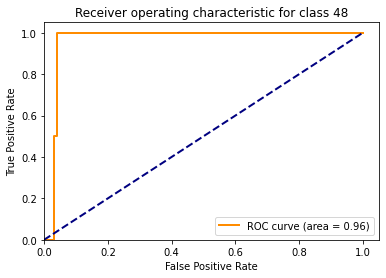

In [26]:
calc_and_plot(clf_rfc, X_test, y_test)

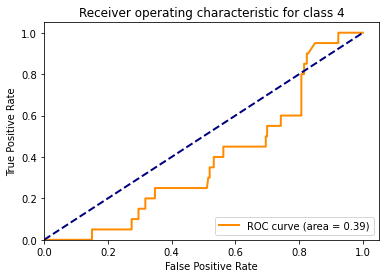

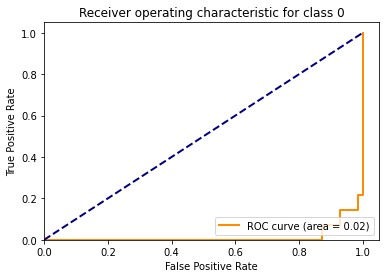

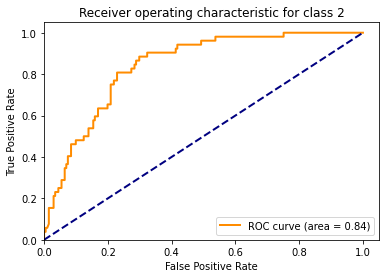

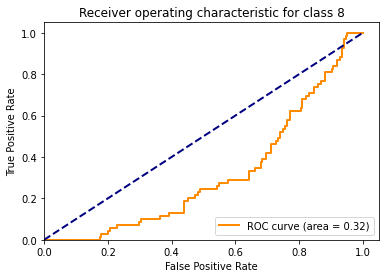

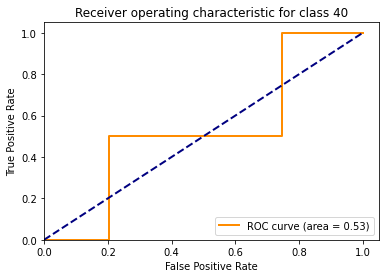

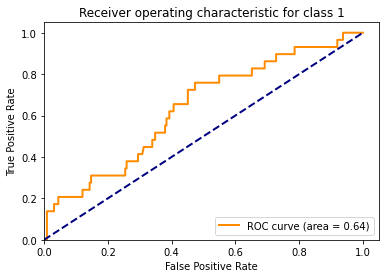

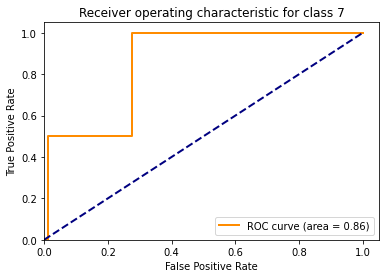

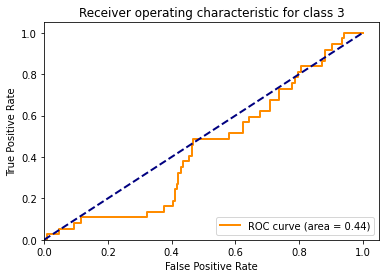

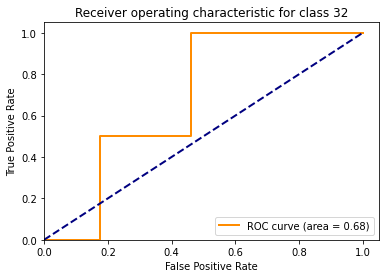

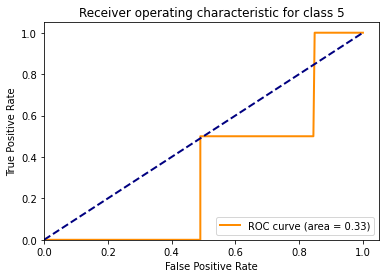

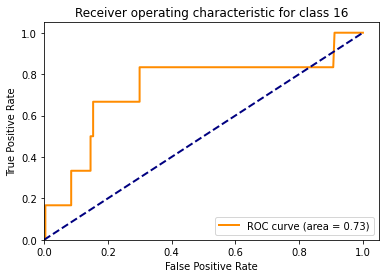

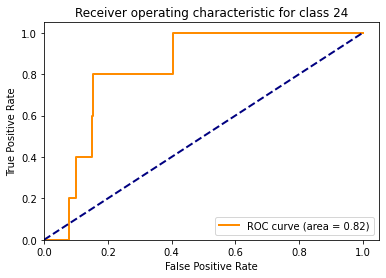

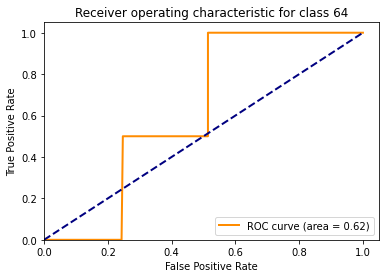

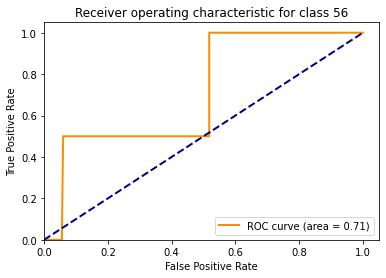

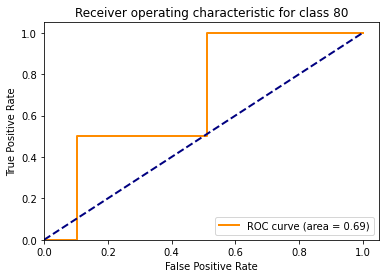

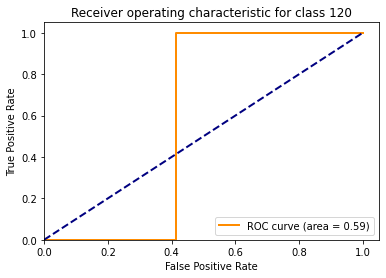

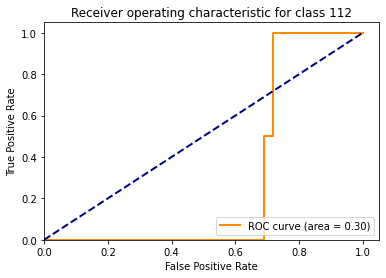

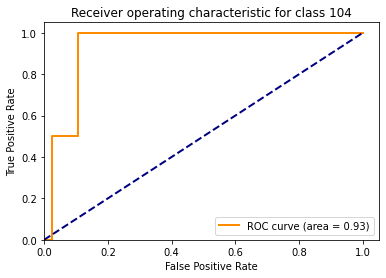

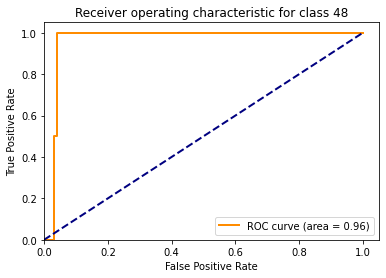

In [27]:
calc_and_plot(clf_gbc, X_test, y_test)